# Data Clinic <> Analytics Exchange Workshop - October 19, 2022

### Learning Objectives

- Access census estimates and NYC open datasets using python.
- Join these NYC Open Source datasets with Census variables via spatial joins.
- Visualize these data in interactive maps


### Datasets

1. American Community Survey 5-year 2019 estimates
2. Community District Tabulation Area file
3. NYC road network datasets.
4. NYC Citi Bike locations dataset

### Set-up

Before we get started, execute the first 2 cells below to set up your work environment.

Pro-tip: Press `shift` + `return` to run a cell.

In [1]:
# Run this cell at the start of the workshop
%pip install cenpy
import cenpy as cp
import pandas as pd
import numpy as np
import geopandas as geopd
import plotly.express as px
import json
import warnings
import urllib.request
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1.0 MB 18.2 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1.0 MB 42.1 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 2.4 MB 36.7 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6.3 MB 20.4 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 16.7 MB 650 kB/s 
  Created wheel for cenpy: filename=cenpy-1.0.1-py3-none-any.whl size=30059 sha256=e075aeea3cd0d26d5b39740bb04f9f925dc5bb79408592fdaff5137ae7cb8d58
  Stored in directory: /root/.cache/pip/wheels/7f/5c/d8/459cb49ab185291b4906ac42dde99ee6b264aa279a721caa60
Successfully built cenpy


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Run this cell at the start of the workshop
def load_crosswalk_dataframe():
  CROSSWALK_URL = "https://www1.nyc.gov/assets/planning/download/office/planning-level/nyc-population/census2020/nyc2020census_tract_nta_cdta_relationships.xlsx?r=092221"
  crosswalk = pd.read_excel(CROSSWALK_URL)
  crosswalk = crosswalk[crosswalk["CDTAType"] == "CD"]
  crosswalk = crosswalk[["GEOID", "CDTACode"]]
  crosswalk["GEOID"] = crosswalk["GEOID"].astype(str)
  return crosswalk

def load_community_district_dataframe():
  CD_url = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_District_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
  CDs = geopd.read_file(CD_url)
  CDs = CDs[CDs["CDTAType"] == "0"]
  CDs["area_sq_mi"] = CDs["Shape__Area"] / (5280**2)
  CDs = CDs[["CDTAName", "CDTA2020", "area_sq_mi", "BoroName", "geometry"]]
  CDs = CDs.to_crs("EPSG:2263") # "Flattens" the districts so that we can overlay the bike network and calculated distances directly
  return CDs

def load_bike_lanes_dataframe():
  bike_url = "https://data.cityofnewyork.us/api/geospatial/7vsa-caz7?method=export&format=GeoJSON"
  bike_lanes = geopd.read_file(bike_url)[["geometry"]]
  bike_lanes = bike_lanes.to_crs("EPSG:2263") # Changing projection so that lengths can be calculated
  return bike_lanes

def load_roads_dataframe():
  road_url = "https://data.cityofnewyork.us/api/geospatial/exjm-f27b?method=export&format=GeoJSON"
  roads = geopd.read_file(road_url)[["geometry"]]
  roads = roads.to_crs("EPSG:2263")
  return roads

def calculate_bike_to_roadway_ratio():

  # calculate the length of each segment of bikelane
  bike_lanes_cd["length_feet"] = bike_lanes_cd["geometry"].length
  roads_cd = roads.overlay(CDs)
  # calculate the length of each segment of roadway
  roads_cd["length_feet"] = roads_cd["geometry"].length

  '''
  We now have two datasets that represented bike lanes and roads 
  within each community district and the length of each of the 
  resulting road/bike lane segments. 
  
  To combine these data, we just need to join them based on 
  their community district.

  We can estimate a crude measure of bike lane density by first 
  adding together the lengths of the bike lanes and roads within 
  each community district and then dividing the bike lane total 
  by the road total. This ratio represents the miles of bike 
  lane that exist per mile of road in each community district.

  '''

  total_road_lengths = (
    roads_cd.groupby("CDTA2020")
    .agg(total_road_length = ("length_feet", "sum"))
    .reset_index()
    )

  total_bike_lengths = (
    bike_lanes_cd.groupby("CDTA2020")
    .agg(total_bike_length = ("length_feet", "sum"))
    .reset_index()
    )
  
  combined_lengths = total_road_lengths.merge(total_bike_lengths)
  # calculate the ratio
  combined_lengths["bike_lane_ratio"] = combined_lengths["total_bike_length"] / combined_lengths["total_road_length"]

  return combined_lengths

def load_citibike_dataframe():
  citi_bike_url = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"
  with urllib.request.urlopen(citi_bike_url) as f:
    citi_json = json.loads(f.read())

  citi_json = citi_json['data']['stations']
  citi_data = pd.json_normalize(citi_json)
  citi_data

  citi_data["geometry"] = geopd.points_from_xy(citi_data["lon"], citi_data["lat"])
  citi_data_geo = geopd.GeoDataFrame(citi_data, crs = "EPSG:4326")
  citi_data_geo = citi_data_geo[citi_data_geo["name"] != "4567.07"]

  return citi_data_geo[["name", "geometry"]]

citi_bike_stations = load_citibike_dataframe()
crosswalk = load_crosswalk_dataframe()
CDs = load_community_district_dataframe()
bike_lanes = load_bike_lanes_dataframe()
roads = load_roads_dataframe()

# About the Data

### American Community Survey Data

- The American Community Survey (ACS) is conducted annually by the US Census Bureau. Like the decennial census, the ACS asks respondents about their demographics and location. However, the ACS is only administered to a sample of households (about 3% per year) and includes questions about employment, education, technology, and more. Because of its scale and depth, the ACS is widely used across government and academic research and is an excellent resource for gathering information about how people live in the United States.


- Cenpy is a python package that provides easy access to the Census API (which includes ACS data). Using Cenpy, we can select an area of interest and a set of variables which Cenpy will then retrieve from the Census API.

---

###  About NYC Open Data Portal

- New York City publishes thousands of datasets as freely available â€œopen dataâ€ on its open data hub [https://opendata.cityofnewyork.us/]. These datasets span topics such as 911 calls, building permits, restaurants inspections and much more. Many of these datasets are spatial data.

---

### About "Spatial" Data

- A "Spatial" dataframe looks just like any other dataframe, but it is augmented with a special column - "geometry." This column contains data in a coordinate (e.g. latitude/longitude) and defines a geometric object such as a point (e.g. locations of hospitals), line (e.g. highway paths), or polygon (e.g. school district boundaries). 

- Spatial data can be stored in various ways, but the two most common formats are geojson and shapefiles - so if you see files in one of those formats, know that they almost certainly contain spatial data of one form or another.

In this workshop, we'll cover some of the basics of working with spatial data, including point, line, and polygon data and conducting simple kinds of spatial joins.

---
# Bicycle Use Case

### Context

Bicycle commuting is becoming a more common way for people to get to work in NYC and beyond. Cities can make bike commuting safer and more popular by providing suitable infrasture such as bike lanes and bike share programs.


### Task

Create a spatial dataset at the community district level that merges census estimates with bike infrastructure metrics derived using open data.


### Approach

Use the American Community Survey (ACS) and New York City's bike lane and road network datasets to analyze how bike lane infrastructure and bike commuting are related in New York City. 

- Step 1: Use the python library Cenpy to download data from the Census API. Select variables that describe how many people commute to work using bikes for each of NYCâ€™s census tracts.

- Step 2: Load data from NYC Open Data that gives the spatial boundaries of NYCâ€™s community districts. Map census tracts to community districts using a crosswalk provided by NYC, and aggregate the ACS data for each community district.

- Step 3: Use open data sources to gather information about bike infrastructure across the city and aggregate it to the commutity districts.

- Step 4: Merge the ACS commuting data with this measure of bike infrastructure data and produce several interactive visualizations.



# Step 1: Use the python library Cenpy to download data from the Census API. 


- Select variables in the ACS that describe how many people commute to work using bikes for each of NYCâ€™s census tracts.

- We'll use the Cenpy library to explore and query the US Census API. Find more examples of how to use cenpy here: [Cenpy Github](https://nbviewer.org/github/cenpy-devs/cenpy/blob/master/notebooks/product-api.ipynb).


In [3]:
# 1.1
acs = cp.products.ACS(2019)
acs_vars = acs.variables.reset_index()

See the column called, `index`?  The Census Bureau uses a particular annotation system to organize census estimates. Unfortunately for us, this convention isn't particuarly intuitive.

In [4]:
# 1.2
acs_vars.head()

index             label                   concept predicateType  \
0        AIANHH         Geography                       NaN           NaN   
1        AIHHTL         Geography                       NaN           NaN   
2         AIRES         Geography                       NaN           NaN   
3          ANRC         Geography                       NaN           NaN   
4  B01001A_001E  Estimate!!Total:  SEX BY AGE (WHITE ALONE)           int   

     group limit predicateOnly hasGeoCollectionSupport  \
0      N/A     0           NaN                     NaN   
1      N/A     0           NaN                     NaN   
2      N/A     0           NaN                     NaN   
3      N/A     0           NaN                     NaN   
4  B01001A     0           NaN                     NaN   

                                 attributes required  
0                                       NaN      NaN  
1                                       NaN      NaN  
2                                       NaN      NaN  
3                                       NaN      NaN  
4  B01001A_001EA,B01001A_001M,B01001A_001MA      NaN

We used the website [Census Reporter](https://censusreporter.org) to navigate the census data and figure out what variables might interest us and what they are called by the Census Bureau.

> Census Reporter is an independent project to make it easier for journalists to write stories using information from the U.S. Census bureau. Place profiles and comparison pages provide a friendly interface for navigating data, including visualizations for a more useful first look.


**Here's how we found the variables suited to our use case...**

1. Navigate to the Census Reporter homepage
2. Scroll down to the section "Topics"
3. Click on Commute
4. We see there is a survey question and data table dedicated to `Means of Transportation to Work`. The census table code is [B08301](https://censusreporter.org/tables/B08301/)


In [5]:
# 1.3
# Using the code below, you can search for all census variables in data table B0831

TABLE_CODE = "B08301"
acs_vars[acs_vars["group"] == TABLE_CODE].head(3) # Show the top 5 results for all row records whose index column value starts with our table code of interest

index                                              label  \
5266  B08301_001E                                   Estimate!!Total:   
5267  B08301_002E              Estimate!!Total:!!Car, truck, or van:   
5268  B08301_003E  Estimate!!Total:!!Car, truck, or van:!!Drove a...   

                              concept predicateType   group limit  \
5266  MEANS OF TRANSPORTATION TO WORK           int  B08301     0   
5267  MEANS OF TRANSPORTATION TO WORK           int  B08301     0   
5268  MEANS OF TRANSPORTATION TO WORK           int  B08301     0   

     predicateOnly hasGeoCollectionSupport  \
5266           NaN                     NaN   
5267           NaN                     NaN   
5268           NaN                     NaN   

                                 attributes required  
5266  B08301_001EA,B08301_001M,B08301_001MA      NaN  
5267  B08301_002EA,B08301_002M,B08301_002MA      NaN  
5268  B08301_003EA,B08301_003M,B08301_003MA      NaN

**After reviewing the table, we narrow down our search to a subset of variables, download them from the census API, and rename them.**

In [6]:
# 1.4
PLACE = 'New York, NY'
NYC_COUNTY_CODES = ["061", "081", "005", "047", "085"]
VARIABLES = {"B08301_001E" : "total_workers_over_16","B08301_018E" : "total_bike_commuters"}

NYC_bike_data = acs.from_place( # Cenpy also allows you to summarize variables by couny, subcounty, state, and other geos!
    PLACE,
    variables = VARIABLES,
    strict_within=False
    )

NYC_bike_data = NYC_bike_data[NYC_bike_data["county"].isin(NYC_COUNTY_CODES)].rename(VARIABLES, axis = 1).to_crs("EPSG:4326")
NYC_bike_data = NYC_bike_data[NYC_bike_data["total_workers_over_16"] > 0] # remove rows where there aren't any workers over 16

NYC_bike_data.head(3)

Matched: New York, NY to New York city within layer Incorporated Places


GEOID                                           geometry  \
6   36085024800  POLYGON ((-74.25817 40.50816, -74.25813 40.508...   
27  36085017012  POLYGON ((-74.18128 40.54696, -74.18018 40.548...   
34  36085015602  POLYGON ((-74.16901 40.54010, -74.16823 40.540...   

    total_workers_over_16  total_bike_commuters state county   tract  
6                  2365.0                   0.0    36    085  024800  
27                 1835.0                   0.0    36    085  017012  
34                 1531.0                   0.0    36    085  015602

### Variable Definitions
- **GEO_ID**: A unque alphanumerical label assigned to each census geography.
- **total_workers_over_16**: The total number of workers in this geography  that is employed and over the age of 16 as of April 2020.
- **total_bike_commuters**: The total number of workers that report commuting to work on a bicycle
- **geometry**: This is how we represent areas on a map. The field contains at least three sets of coordinate tuples that forms the outerior perimeter of the polygon.

In [7]:
# 1.5
VARIABLES_TO_KEEP = ["GEOID", "total_workers_over_16", "total_bike_commuters", "geometry"]

NYC_bike_data = NYC_bike_data[VARIABLES_TO_KEEP]
NYC_bike_data.sort_values(by=["total_bike_commuters"], ascending=False).head(3)

GEOID  total_workers_over_16  total_bike_commuters  \
107   36061003800                 5595.0                 450.0   
1575  36061003200                 4552.0                 417.0   
1631  36061024100                 4832.0                 366.0   

                                               geometry  
107   POLYGON ((-73.99164 40.72683, -73.99155 40.727...  
1575  POLYGON ((-73.98705 40.72520, -73.98662 40.725...  
1631  POLYGON ((-73.95870 40.83773, -73.95802 40.839...

# Step 2: Load data provided by the city that gives the spatial boundaries of NYCâ€™s community districts. 

**Mapping Census Geographies to NYC-specific geographies**

We're performing a crosswalk to map standard census geographies to custom NYC geographies. Here, we are translating tracts to community districits. This way we can ultimately represent this data at the community district level.

**Why do we need to do this at all? Why can't we use standard census geographies?**

You certainly can, but it might hinder your ability to draw meaningful conclusions from your analysis. This data is summarised at the "Census tract" level - the lowest granularity that most ACS variables are available at. However, as the map below shows, the Census tracts are actually quite small and don't represent the city in a way that corresponds with intuitive geographic divisions.

In [8]:
# 2.1
merged_geojson =  json.loads(NYC_bike_data.to_json())
fig = px.choropleth_mapbox(NYC_bike_data, 
                    geojson = merged_geojson,
                    locations="GEOID", 
                    featureidkey = "properties.GEOID",
                    color= "total_workers_over_16", # change this parameter to change the variable you'd like to visualize
                    color_continuous_scale="Viridis",
                    zoom=9, 
                    center = {"lat": 40.7306, "lon": -73.9352},
                    opacity = .7,
                          )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

### Schema Crosswalk Census Tracts <> NYC Community Districts

For this reason, we perform a "crosswalk" from the Census tracts to NYC's "Community Districts" - a city-defined geography with administrative meaning.

With the crosswalk file and our tract-level census data, its straight-forward to calculate the commuting variables at the community district level. 

- Join the census data to the crosswalk using the tract-level GEOID identifier.

- Within each community district, sum the tract-level counts using the "groupby" and "agg" functions

- Since we want to compare the proportion of workers who commute by bike rather than the raw total, we compute the ratio of the total number of bike commuters to the total number of workers. When multiplied by 100, this ratio describes the percentage of workers over 16 who commute to work by bicycle in each commuity district.

In [9]:
# 2.2
print("Crosswalk File...")
crosswalk.head(3)

Crosswalk File...


GEOID CDTACode
0  36005001901     BX01
1  36005001902     BX01
2  36005001903     BX01

In [10]:
# 2.3

# Join the census data to the crosswalk using the tract-level GEOID identifier
# Within each community district, sum the tract-level counts using the "groupby" and "agg" functions
CD_bike_data = (
    NYC_bike_data.merge(crosswalk)
    .groupby("CDTACode")
    .agg(total_workers = ("total_workers_over_16", "sum"), total_bike_commuters = ("total_bike_commuters", "sum"))
    .reset_index()
    )

# compute the ratio of the total number of bike commuters to the total number of workers
CD_bike_data["bike_percent"] = round(100 * CD_bike_data["total_bike_commuters"] / CD_bike_data["total_workers"], 2)
CD_bike_data.head(3)

CDTACode  total_workers  total_bike_commuters  bike_percent
0     BK01        85665.0                2971.0          3.47
1     BK02        58219.0                1987.0          3.41
2     BK03        81222.0                2618.0          3.22

The next thing we do is load a file that contains the geographic boundaries - i.e polygons) of each community district.

In [11]:
# 2.4
print("Community District file...")
CDs.head(3)

Community District file...


CDTAName CDTA2020  area_sq_mi  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)     BK01    4.722643   
1  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...     BK02    2.723042   
2       BK03 Bedford-Stuyvesant (CD 3 Approximation)     BK03    2.804902   

   BoroName                                           geometry  
0  Brooklyn  POLYGON ((1005302.100 199458.739, 1005307.395 ...  
1  Brooklyn  POLYGON ((992763.167 196894.152, 993013.733 19...  
2  Brooklyn  POLYGON ((1006978.212 189660.388, 1006991.377 ...

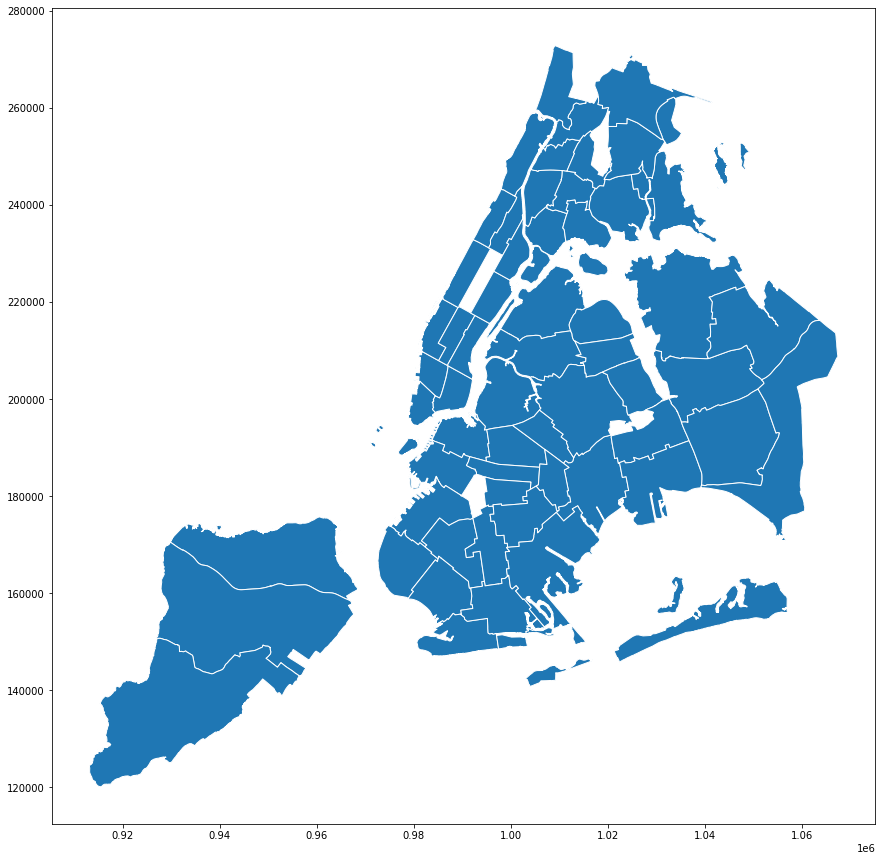

In [12]:
# 2.5
CDs.plot(figsize = [15,15], edgecolor='white', linewidth=1)

In [13]:
# 2.6
print("Results of our crosswalk...")
CD_bike_geo = CDs.merge(CD_bike_data, left_on = "CDTA2020", right_on = "CDTACode").drop("CDTACode", axis = 1)
CD_bike_geo.head(3)

Results of our crosswalk...


CDTAName CDTA2020  area_sq_mi  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)     BK01    4.722643   
1  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...     BK02    2.723042   
2       BK03 Bedford-Stuyvesant (CD 3 Approximation)     BK03    2.804902   

   BoroName                                           geometry  total_workers  \
0  Brooklyn  POLYGON ((1005302.100 199458.739, 1005307.395 ...        85665.0   
1  Brooklyn  POLYGON ((992763.167 196894.152, 993013.733 19...        58219.0   
2  Brooklyn  POLYGON ((1006978.212 189660.388, 1006991.377 ...        81222.0   

   total_bike_commuters  bike_percent  
0                2971.0          3.47  
1                1987.0          3.41  
2                2618.0          3.22

# Step 3: Use open data sources to gather information about bike infrastructure across the city and aggregate it to the commutity districts.

With the Census data ready, we can move on to the city data. 

- Load in the bike lane and road network data available on the city's open data portal
- Spatially join that data to our community districts. We downloaded the bike lane network data from the city's open data portal earlier in the notebook. This represents the full network of bike lanes and roadways in NYC.

In [14]:
# 3.1
bike_lanes.head(3)

geometry
0  MULTILINESTRING ((914742.992 121858.565, 91480...
1  MULTILINESTRING ((914955.193 121071.349, 91490...
2  MULTILINESTRING ((914902.953 121334.911, 91480...

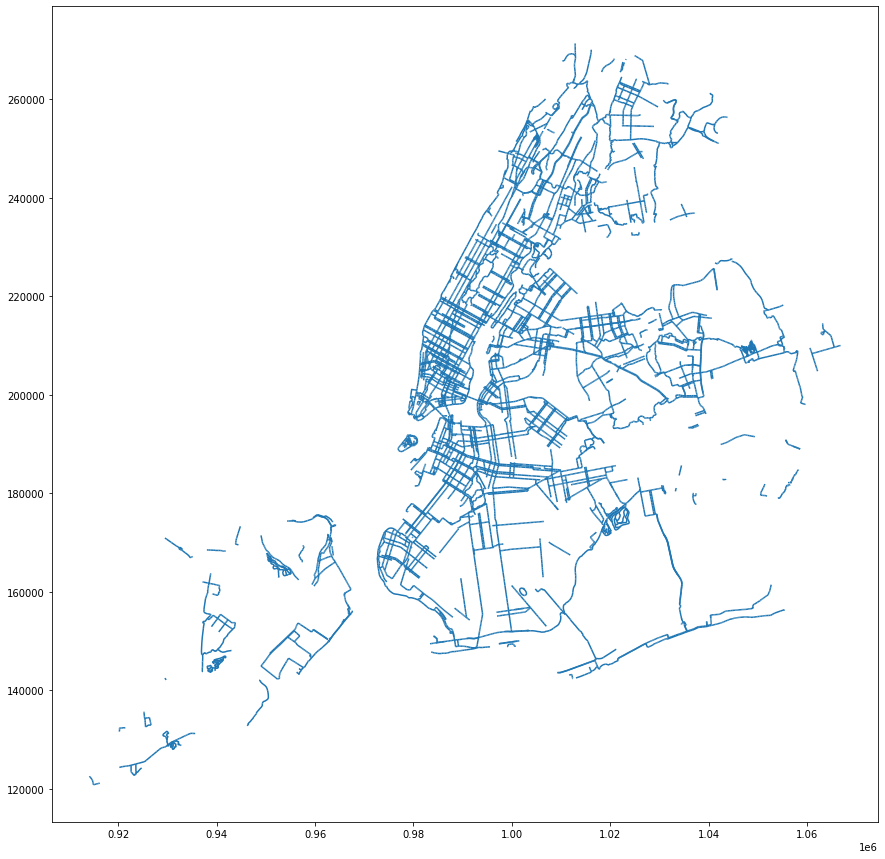

In [15]:
# 3.2
bike_lanes.plot(figsize = [15,15])

To associate each piece of bike lane with the community district it resides in, we use the "overlay" function. This works in the following way:

- The bike lane data is structured as lines with begining and end coordinates. The community district data is structured as polygons with vertices at coordinate points in the same systems. 

- The function "overlays" the bike network onto the polygons, spliting the bike lanes whereever they cross community district boundaries. The function then returns the community district that each bike lane segment lies within.

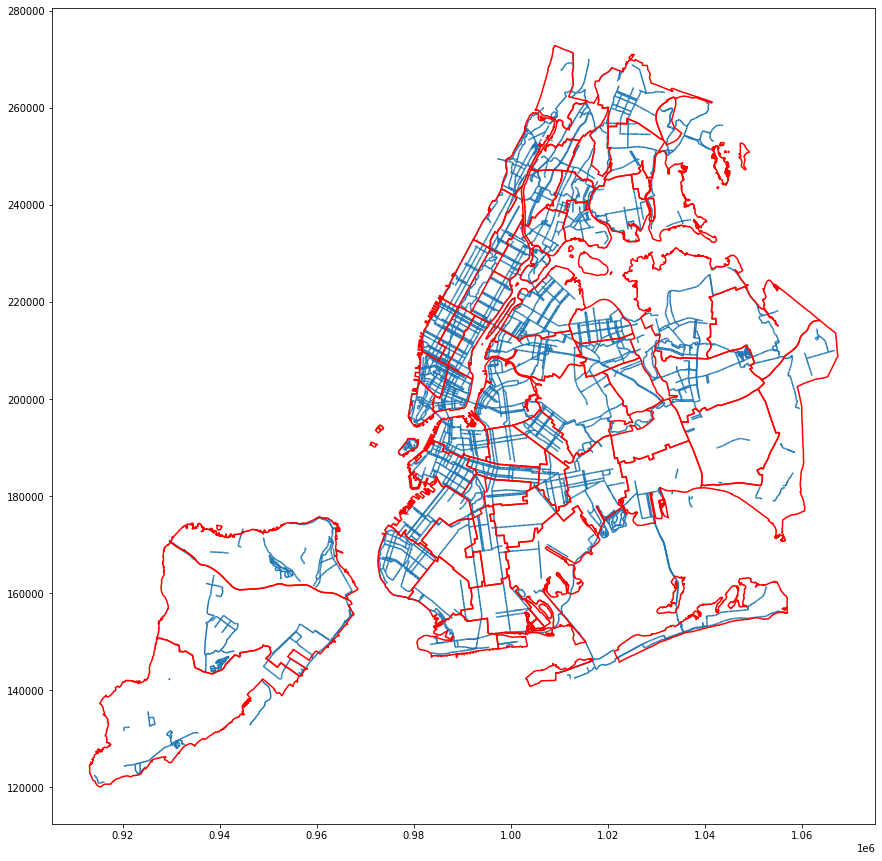

In [16]:
# 3.3
ax = bike_lanes.plot(figsize = [15,15])
CDs.boundary.plot(ax=ax, color = "red")

Below, we plot the bike lanes that are within Brooklyn Community District 2 (Downtown Brooklyn and Fort Green).

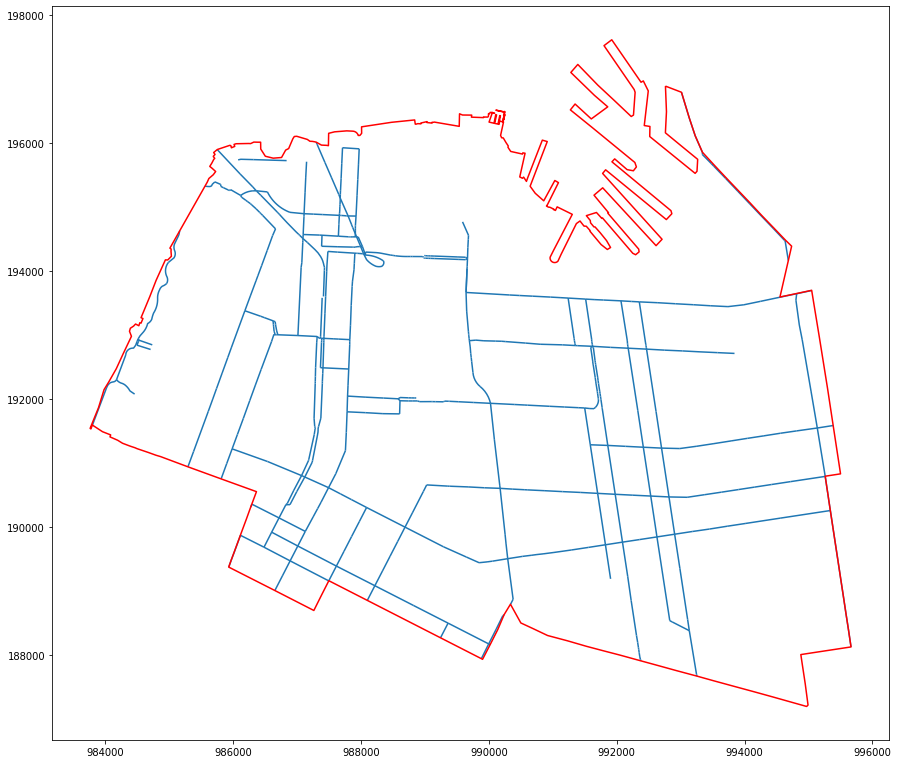

In [17]:
# 3.4
bike_lanes_cd = bike_lanes.overlay(CDs)
ax = bike_lanes_cd[bike_lanes_cd["CDTA2020"] == "BK02"].plot(figsize = [15,15]) # Downtown Brooklyn-Fort Greene
CDs[CDs["CDTA2020"] == "BK02"].boundary.plot(ax = ax, color = "red")

The next step is to calculate the length of each of these segments and use this to calculate the ratio of bike lanes to roadways for each community district.

We won't go through the calculation line-by-line, but feel free to review the explanation below:


> We now have two datasets that represented bike lanes and roads within each community district and the length of each of theresulting road/bike lane segments.
  
> To combine these data, we just need to join them based on their community district.

> We can estimate a crude measure of bike lane density by first adding together the lengths of the bike lanes and roads within each community district and then dividing the bike lane total by the road total. This ratio represents the miles of bike lane that exist per mile of road in each community district. A ratio close to 0 means that a community district has very little bike lane per mile of road while a ratio close to 1 means there is about as much bike lane as road.



In [18]:
# 3.5
combined_lengths = calculate_bike_to_roadway_ratio()

### **Variable Definitions**

**Bike lane ratio**:  represents the miles of bike lane that exist per mile of road in each community district.

**total road length**: combined length of all roads within each community district.

**total bike length**: combined length of all bike lanes within each community district.


In [28]:
# 3.6
combined_lengths.head(10)

CDTA2020  total_road_length  total_bike_length  bike_lane_ratio
0     BK01      743343.564547      155460.288603         0.209137
1     BK02      506749.239127      130837.684913         0.258190
2     BK03      412858.411415       47802.861103         0.115785
3     BK04      285334.147817       66996.624280         0.234801
4     BK06      467368.177423      147585.111056         0.315779
5     BK07      477252.915548       91689.036231         0.192118
6     BK08      250928.991504       85836.247625         0.342074
7     BK09      242479.182858       42658.461919         0.175926
8     BK10      683531.752272      147908.969871         0.216389
9     BK11      585013.571174       38707.609793         0.066165

Bike lanes are a particularly important piece of bike infrastructure but not the only thing we might want to examine. New York City maintains the largest bike share program - Citi Bike - in the United States. Large quantities of Citi Bike data are publically available. Here, we make use of a dataset containing the latitude/longtitude location of each Citi Bike station. 

These coordinates can be represented as a spatial dataframe with a "point" geometry.

We display the loaded data below:

In [20]:
# 3.7
citi_bike_stations.head(3)

name                    geometry
0          W 52 St & 11 Ave  POINT (-73.99393 40.76727)
1  Franklin St & W Broadway  POINT (-74.00667 40.71912)
2    St James Pl & Pearl St  POINT (-74.00017 40.71117)

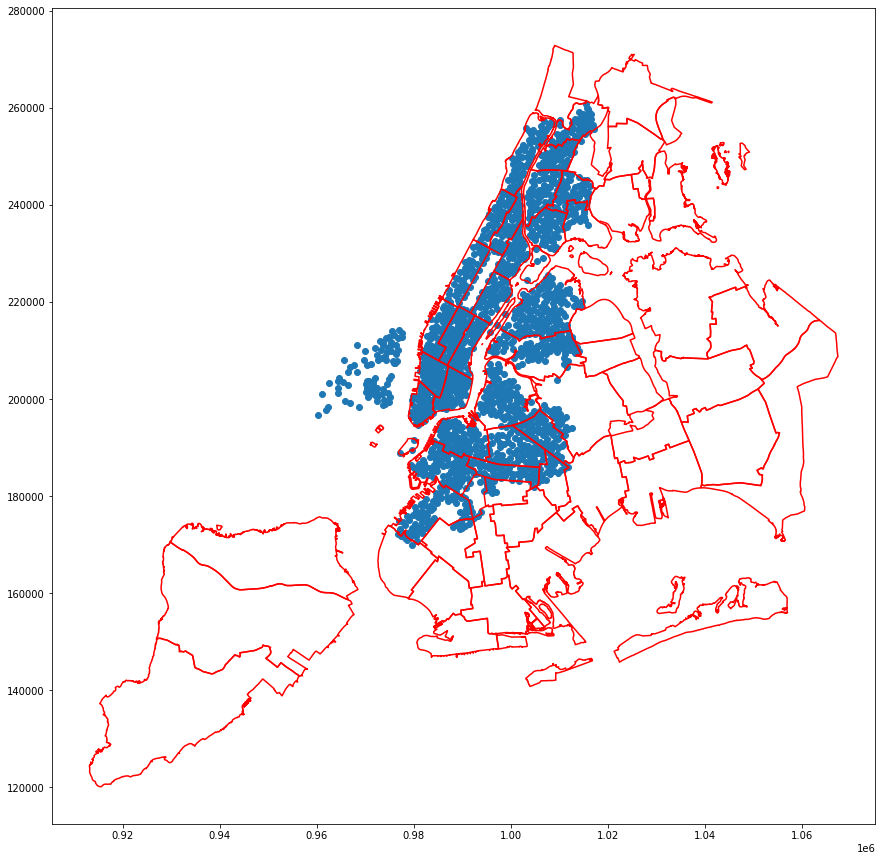

In [21]:
# 3.8
ax = citi_bike_stations.to_crs("EPSG:2263").plot(figsize = [15,15])
CDs.boundary.plot(ax = ax, color = "red")

In [22]:
# 3.9
bike_stations_joined = geopd.sjoin(citi_bike_stations.to_crs("EPSG:2263"), CDs)

bike_stations_CD = (bike_stations_joined
                    .groupby(["CDTA2020", "area_sq_mi"])
                    .agg(total_citi_bike_stations = ("name", "count"))
                    .reset_index())

bike_stations_CD["citi_bike_stations_per_sq_mi"] = bike_stations_CD["total_citi_bike_stations"] / bike_stations_CD["area_sq_mi"]

bike_stations_CD.head(3)

CDTA2020  area_sq_mi  total_citi_bike_stations  citi_bike_stations_per_sq_mi
0     BK01    4.722643                        86                     18.210143
1     BK02    2.723042                        80                     29.378912
2     BK03    2.804902                        63                     22.460678

# Step 4:  Merge the ACS commuter type estimates with open date. Visualize the results.

Once we join our two datasets - the census commuting data and the road/bike lane data - by community district we have the final analytic dataset.

In [23]:
# 3.10
final_df_geo = (CD_bike_geo
                .merge(combined_lengths)
                .merge(bike_stations_CD, how = "left")
                .to_crs("EPSG:4326")) # Change projection so that the mapping package will work properly
final_df_geo.head(3)

CDTAName CDTA2020  area_sq_mi  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)     BK01    4.722643   
1  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...     BK02    2.723042   
2       BK03 Bedford-Stuyvesant (CD 3 Approximation)     BK03    2.804902   

   BoroName                                           geometry  total_workers  \
0  Brooklyn  POLYGON ((-73.92406 40.71412, -73.92404 40.714...        85665.0   
1  Brooklyn  POLYGON ((-73.96929 40.70710, -73.96839 40.706...        58219.0   
2  Brooklyn  POLYGON ((-73.91805 40.68722, -73.91800 40.686...        81222.0   

   total_bike_commuters  bike_percent  total_road_length  total_bike_length  \
0                2971.0          3.47      743343.564547      155460.288603   
1                1987.0          3.41      506749.239127      130837.684913   
2                2618.0          3.22      412858.411415       47802.861103   

   bike_lane_ratio  total_citi_bike_stations  citi_bike_stations_per_sq_mi  
0         0.209137                      86.0                     18.210143  
1         0.258190                      80.0                     29.378912  
2         0.115785                      63.0                     22.460678

The map below shows the bike lane density of each community district. It's probably not a surprise that 

In [24]:
# 3.11
merged_geojson =  json.loads(final_df_geo.to_json())

fig = px.choropleth_mapbox(final_df_geo, 
                    geojson = merged_geojson,
                    locations="CDTAName", 
                    featureidkey = "properties.CDTAName",
                    color= "bike_lane_ratio",
                    color_continuous_scale="Viridis",
                    zoom=8, 
                    center = {"lat": 40.7306, "lon": -73.9352},
                    range_color=(0, .43),
                    opacity = .7,
                    labels={'CDTAName':'CDTA Neighborhoods',
                            'bike_lane_ratio':'Miles bike lane / miles road'
                            }
                          )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Here we plot the percent of bike commuters. The CD with the highest percentage is LES-Chinatown with over 5.6% of workers over 16 reporting that they bike to work. In fact, this value is something of an outlier - the rate of bike commuting in the district with the second highest figure, Park Slope-Carroll Gardens is almost two full percentage points lower. We can also see quite clearly that outside of Brooklyn and Manhattan, bike commuting remains  very uncommon, with the rate typically below 1%.

In [25]:
# 3.12
merged_geojson =  json.loads(final_df_geo.to_json()) # FYI plotly forces you to turn your file into a geojson.
 
fig = px.choropleth_mapbox(final_df_geo, 
                    geojson = merged_geojson,
                    locations="CDTAName", 
                    featureidkey = "properties.CDTAName",
                    color= "bike_percent",
                    color_continuous_scale="Viridis",
                    zoom=8, 
                    center = {"lat": 40.7306, "lon": -73.9352},
                    opacity = .7,
                    labels={'CDTAName':'CDTA Neighborhoods',
                            'bike_percent':'Percent bike commuters'
                            }
                          )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In the scatter plot below, we see and interesting trend. First, as we might expect, higher bike lane density is assoicated with higher rates of bike commuting. However, the strength of this trend varies greatly by borough. In Brooklyn, the relationship is strongest, with each additional tenth mile of bike lane per mile of road being associated with a 1.1% increase in the percentage of workers who commute by bike. In the Bronx, this association is near 0, and is in fact slightly negative. This plot can also show us where the biggest gaps are between the amount that residents commute by bike and the bike lane density of their district. For instance, in Bedford-Stuyvesant, the trend line would predict that only 1.2% of workers would commute by bike, but in fact, over 3% do so.

In [26]:
# 3.13
px.scatter(final_df_geo[final_df_geo["BoroName"].isin(["Brooklyn", "Bronx"])], x="bike_lane_ratio", y="bike_percent", trendline="ols", color = "BoroName", hover_name="CDTAName")

This scatterplot shows that LES-Chinatown has both the highest rate of bike commuting and the highest density of Citi Bike stations.

In [27]:
# 3.14
px.scatter(final_df_geo, x="citi_bike_stations_per_sq_mi", y="bike_percent", trendline="ols",hover_name="CDTAName")

# About the Data Clinic

### Mission & Contact

The Data Clinic provides pro bono data and technology support to non-profits and mission driven organizations. We are always looking for new partnerships - don't hestitate to send an org you love our way! We can be reached via email at dataclinic@tsdataclinic.com.

For more information on how we work, past partnerships, and information on our open source tooling visit https://www.twosigma.com/data-clinic/.
